# Snorkel MeTaL for Brexit

### Setup

In [1]:
import sys
import os
sys.path.append('../../metal')
import metal

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Step 1: Load Data

The first step in a Snorkel MeTaL application is preparing your data.

### Concept 1: Required Data Types

In particular, MeTaL makes use of the following types of data (n = # examples, m = # labeling functions):
* X: an \[n\]-dim iterable of end model inputs (e.g., feature vectors or encoded sentences for an RNN)
* Y: an \[n\]-dim numpy.ndarray of target labels ($Y \in \{1,...,k\}^n$)
* L: an \[n,m\] scipy.sparse matrix of noisy labels ($L \in \{0,...,k\}^{n \times m}$, with label 0 reserved for abstentions


In [3]:
import scipy.sparse
import numpy as np
L = scipy.sparse.load_npz('data/gold_label_matrix.npz')
Y = np.load('data/gold_labels.npy', allow_pickle=True)
X = scipy.sparse.load_npz('data/matrix_for_new_labels.npz')

In [4]:
print(Y.shape)
print(L.shape)
print(X.shape)

(500,)
(500, 5)
(2684, 5)


If you need to divide your data into splits, you can do so with the provided utility function. We split our data 80/10/10 into train/dev/test, stratifying by the labels in `Y` to ensure a similar class balance in each split.

### Investigate Label Matrices

MeTaL comes with a number of analysis tools for investigating your label matrix. 
For example, you can view summary statistics for each labeling function.
If you have a dev set with gold labels, you can view the empirical accuracy of your functions, in addition to the core summary statistics. If you do not have a dev set with gold labels, simply do not specify optional argument Y.

Polarity is a list of classes that a labeling function (LF) predicts for one or more examples. Coverage is the fraction of examples that the labeling function predicts over (as opposed to labeling 0 to abstain). Overlaps is the fraction of examples that the labeling function predicts over that at least one other LF predicts over as well. Conflicts is the fraction of examples that the LF predicts as one class but at least one other LF predicts that same example as a different class. Correct, Incorrect, and Empirical Accuracy are all comparisons to the gold standard labels and thus omitted if Y is not specified.

In [5]:
from metal.analysis import lf_summary

lf_summary(L,Y=Y)

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
0,1,0.268,0.170,0.084,89,45,0.664179
1,1,0.116,0.116,0.030,42,16,0.724138
2,2,0.248,0.146,0.060,91,33,0.733871
3,2,0.066,0.036,0.016,19,14,0.575758
4,2,0.136,0.108,0.034,41,27,0.602941


If you're interested in more graphical investigative tools, you can take a look at the Visualization tutorial.  
Once you're satisfied with your label matrices, it's time to aggregate the labels using the label model and train an end model with the resulting probabilistic labels.

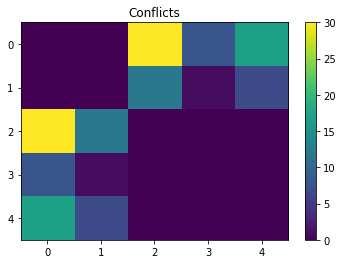

In [6]:
from metal.contrib.visualization.analysis import view_conflicts

if 'CI' not in os.environ:
    view_conflicts(L, normalize=False)

## Step 2: Train Label Model

### Label Model

When constructing a LabelModel, the only required argument is `k`, the cardinality of the task. For example, k=2 means a binary classification task where 1 and 2 are the class labels, and 0 is reserved for an abstain.

In [7]:
from metal.label_model import LabelModel
label_model = LabelModel(k=2, seed=123)

The only required argument to `LabelModel.train_model()` is a label matrix. All other keyword arguments are optional. 

For example, if you know the class_balance of your data, you can pass that in as a list or array; alternatively, you may pass in the target labels of your dev set (`Y_dev`) and have the class balance estimated from that. If neither of these is provided, the classes are assumed to be uniformly distributed.

Any other keyword arguments (e.g., the number of epochs (`n_epochs`), logging frequency (`log_train_every`), learning rate (`lr`), L2 regularization (`l2`), optimizer type (`optimizer`), etc.) will be used to update the config dict.

In [19]:
%%time
label_model.train_model(L, Y_dev=Y, n_epochs=500, log_train_every=50)

Computing O...
Estimating \mu...
[50 epo]: TRAIN:[loss=0.013]
[100 epo]: TRAIN:[loss=0.009]
[150 epo]: TRAIN:[loss=0.008]
[200 epo]: TRAIN:[loss=0.007]
[250 epo]: TRAIN:[loss=0.007]
[300 epo]: TRAIN:[loss=0.006]
[350 epo]: TRAIN:[loss=0.006]
[400 epo]: TRAIN:[loss=0.006]
[450 epo]: TRAIN:[loss=0.006]
[500 epo]: TRAIN:[loss=0.006]
Finished Training
CPU times: user 637 ms, sys: 44.7 ms, total: 682 ms
Wall time: 579 ms


You can test the quality of our label model on our dev set as a sanity check, but we'll see if we can do better in Step 3 by using the predictions of the label model to train a discriminative model over a larger feature set than just the outputs of these ten labeling functions.

In [20]:
print('Trained Label Model Metrics:')
scores = label_model.score((L, Y), metric=['accuracy','precision', 'recall', 'f1'])

Trained Label Model Metrics:
Accuracy: 0.602
Precision: 0.596
Recall: 0.632
F1: 0.614
        y=1    y=2   
 l=1    158    107   
 l=2    92     143   


### Classifier Base Class

Following the data programming paradigm, we will use our label model's probabilistic (float) predictions as training labels for a discriminative end model. Because we want probabilistic labels, we use the `predict_proba()` method here. The predictions are in the form of an [n,k] np.ndarray of floats summing to 1.0 in each row, where `Y_ps[i,j]` is the predicted probability of the $i$th data point having true label $j$.

In [21]:
# Y_train_ps stands for "Y[labels]_train[split]_p[redicted]s[oft]"
Y_predicted = label_model.predict_proba(L)
Y_predicted[0:5]

array([[5.00000000e-01, 5.00000000e-01],
       [9.99554623e-01, 4.45377107e-04],
       [9.82690055e-01, 1.73099454e-02],
       [5.00000000e-01, 5.00000000e-01],
       [5.00000000e-01, 5.00000000e-01]])

In [25]:
from metal.analysis import confusion_matrix
Y_dev_p = label_model.predict(L)

        y=1    y=2   
 l=1    150    95    
 l=2    100    155   


### Analysis tools

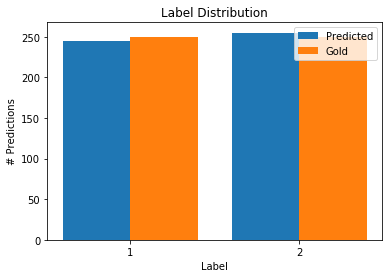

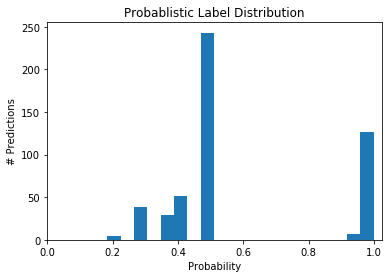

In [29]:
try:
    from metal.contrib.visualization.analysis import (
        plot_predictions_histogram, 
        plot_probabilities_histogram,
    )

    plot_predictions_histogram(Y_dev_p, Y, title="Label Distribution")

    Y_dev_ps = label_model.predict_proba(L)
    plot_probabilities_histogram(Y_dev_ps[:,0], title="Probablistic Label Distribution")

except ModuleNotFoundError:
    print("The tools in contrib/visualization/ require matplotlib. Try `conda/pip install matplotlib`.")

## Step 3: Predict the labels

In [ ]:
labels_on_unlabelled_db = label_model.predict_proba(X)

In [ ]:
labels_on_unlabelled_db

In [ ]:
np.save('new_labels', labels_on_unlabelled_db)